In [1]:
    %pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualisation library
import seaborn as sns # data visualisation library

# preprocessing, classification model and metrics, sampling and model interpretation libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc, 
    precision_recall_curve, accuracy_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import shap

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Introduction

Stroke is one of the leading causes of death and long-term disability worldwide. According to the World Health Organisation (WHO), it accounts for about 11% of total global deaths. Early identification of individuals at high risk can significantly improve prevention and treatment outcomes.

This project aims to build a machine learning model capable of predicting whether a person is likely to experience a stroke based on various factors: health (such as age, hypertension, heart disease, average glucose level, body mass index (BMI), and smoking status), and lifestyle (residence_type, marital_status, work_type). 

By analysing these attributes, the model aims to identify the most important attributes for predictng stroke in patients and uncover key patterns and risk factors associated with stroke, supporting data-driven healthcare decisions and early intervention strategies.

# The Data

In [3]:
data = pd.read_csv(
    r'/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv'
)

data.head()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
data[data.isna().any(axis = 1)]

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


*target variable - 'stroke'*

*independent variables - 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'*


**Note** - 201 missing values in 'bmi'.
Impute missing values or Drop?
I'll answer after exploration of the dataset. Let's see if there's a pattern to it.

# Data Exploration

## Target Exploration

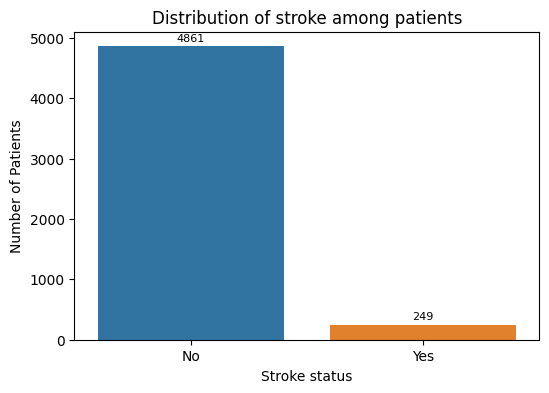

In [6]:
stroke_rate = data['stroke'].value_counts().reset_index()
stroke_rate.columns = ['Stroke', 'Count']

# Plot

plt.figure(figsize = (6, 4))
sns.despine()
sns.barplot(
    data = stroke_rate,
    x = 'Stroke',
    y = 'Count'
)
plt.title('Distribution of stroke among patients')
plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])
plt.xlabel('Stroke status')
plt.ylabel('Number of Patients')

plt.yticks(fontsize = 10)

for i, row in stroke_rate.iterrows():
    plt.text(x = i, y = row['Count'] + max(stroke_rate['Count']) * 0.01,
            s = row['Count'], ha = 'center', va = 'bottom', fontsize = 8)
    
plt.show()

There is an imbalance in the target class of the dataset.

Only about 4.87% patients have stroke.

I'll address this class imbalance with an over-sampling method - SMOTE

## Feature Exploration

In [7]:
# The dataset has both numerical features and categorical features

num_data = data[['age', 'avg_glucose_level', 'bmi']]
cat_data = data[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]

### Numerical Feature Exploration

In [8]:
num_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


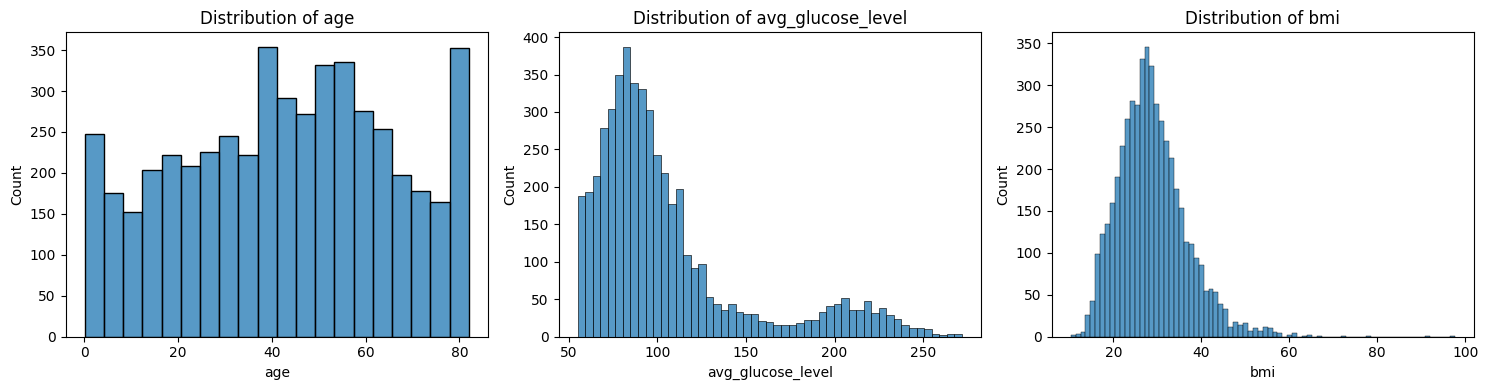

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

ax = ax.flatten()

for i, col in enumerate(num_data.columns):
    sns.histplot(data = num_data.dropna(), x = col, ax = ax[i]).set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

### Categorical Feature Exploration

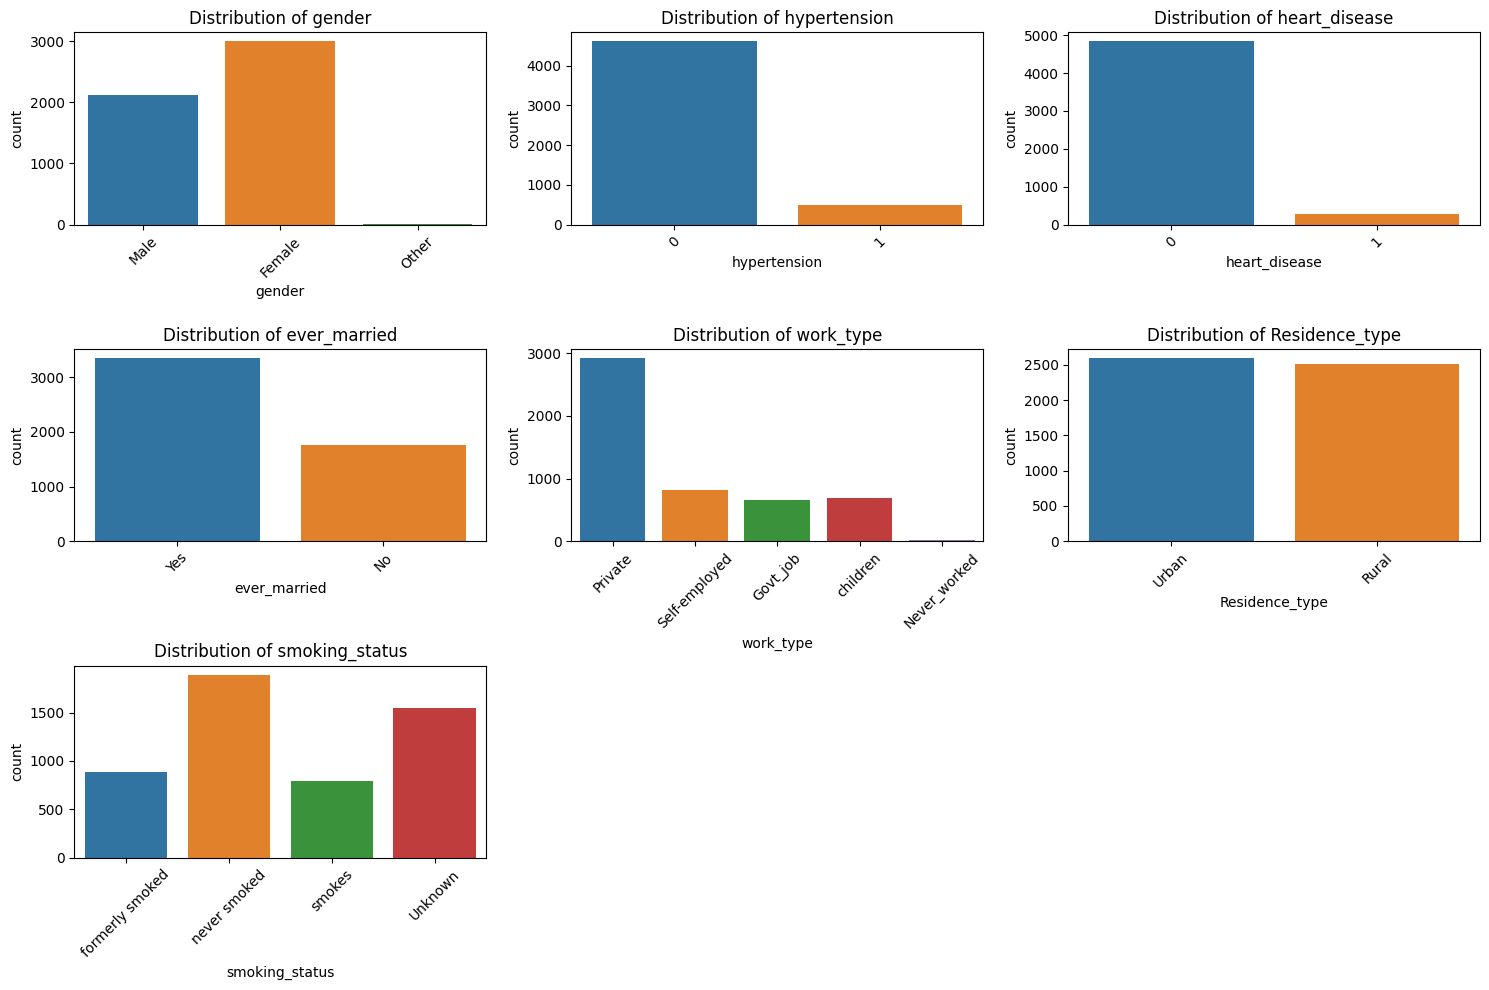

In [10]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
ax = ax.flatten()

for i, col in enumerate(cat_data.columns):
    sns.countplot(data = cat_data, x = col, ax = ax[i])
    ax[i].set_title(f'Distribution of {col}')
    ax[i].tick_params(axis = 'x', rotation=45)

# Leave the last two subplots blank
for j in range(len(cat_data.columns), 9):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

### Insight: Patient Profile

In the dataset, the average patient is:

| Attribute             | Median Value | Description                                                                 |
|----------------------|------------|-----------------------------------------------------------------------------|
| Age                  | 45      | Middle-aged; wide range from infancy to elderly (0.08 to 82 years)         |
| Average Glucose Level| ~ 92     | Slightly elevated; may indicate prediabetes or diabetes risk               |
| Body Mass Index (BMI)| 28.1     | Overweight; median BMI also suggests many patients are overweight or obese |



* The dataset is also female-dominated (~ 58%), 
* Most patients are healthy (have no history of heart disease or hypertension). Maybe this is because most have never smoked.
* Most patients have been or are married and are employed, working in either the private sector or have a government job or run a business. 


## Feature-Target Relationship

The aim here is to uncover how features are strongly associated with stroke

In [11]:
# stroke rate among the numerical features
stroke_group_median = data.groupby('stroke')[['age', 'avg_glucose_level', 'bmi']].median().reset_index()
stroke_group_median['stroke'] = stroke_group_median['stroke'].map({0: 'No', 1: 'Yes'})
stroke_group_median

,stroke,age,avg_glucose_level,bmi
0,No,43.0,91.47,28.0
1,Yes,71.0,105.22,29.7


- Patients who experienced a stroke tend to be significantly older.
- They also show higher median glucose levels and slightly higher BMI.

This suggests age and glucose level may be strong predictors of stroke risk. 


In [12]:
# Stroke rate across classes in the categorical features

for col in cat_data.columns:
    rate = data.groupby(col)['stroke'].mean().reset_index()
    rate.columns = [col, 'Stroke Rate']
    rate['Stroke Rate'] = (rate['Stroke Rate'].round(3) * 100)
    print(f'\nStroke Rate by {col}:\n', rate)


Stroke Rate by gender:
    gender  Stroke Rate
0  Female          4.7
1    Male          5.1
2   Other          0.0

Stroke Rate by hypertension:
    hypertension  Stroke Rate
0             0          4.0
1             1         13.3

Stroke Rate by heart_disease:
    heart_disease  Stroke Rate
0              0          4.2
1              1         17.0

Stroke Rate by ever_married:
   ever_married  Stroke Rate
0           No          1.7
1          Yes          6.6

Stroke Rate by work_type:
        work_type  Stroke Rate
0       Govt_job          5.0
1   Never_worked          0.0
2        Private          5.1
3  Self-employed          7.9
4       children          0.3

Stroke Rate by Residence_type:
   Residence_type  Stroke Rate
0          Rural          4.5
1          Urban          5.2

Stroke Rate by smoking_status:
     smoking_status  Stroke Rate
0          Unknown          3.0
1  formerly smoked          7.9
2     never smoked          4.8
3           smokes          5.3


The summary above shows that patients at risk of a stroke are;
- gender: male (highest risk) and female
- unhealthy: have smoked, have heart disease and are hypertensive
- are/have married and are working professionals

Other gender, Children and unemployed patients are at very low risk of a stroke.

## BMI & Rare Categories (gender, work_type)

'Other' patients and patients who have 'never_worked' are very rare categories (which shows from their count in the data). I'll explore these so as to know the appropriate way to handle them, else they add noise to the model.

In [13]:
data[data['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Just one observation for the 'Other' patient and is a non-stroke patient. I'll exclude this from the data.

In [14]:
data['bmi_missing'] = data['bmi'].isnull()

data.groupby('bmi_missing')[['age', 'avg_glucose_level']].mean()

,age,avg_glucose_level
bmi_missing,,
False,42.865374,105.305150
True,52.049154,126.724627


In [15]:
for col in cat_data.columns:
    missing_rate = data.groupby(col)['bmi_missing'].mean().reset_index()
    missing_rate.columns = [col, 'Missing BMI Rate']
    missing_rate['Missing BMI Rate'] = (missing_rate['Missing BMI Rate'] * 100).round(2)
    print(f"\nMissing BMI Rate by {col}:\n", missing_rate)


Missing BMI Rate by gender:
    gender  Missing BMI Rate
0  Female              3.24
1    Male              4.92
2   Other              0.00

Missing BMI Rate by hypertension:
    hypertension  Missing BMI Rate
0             0              3.34
1             1              9.44

Missing BMI Rate by heart_disease:
    heart_disease  Missing BMI Rate
0              0              3.48
1              1             11.96

Missing BMI Rate by ever_married:
   ever_married  Missing BMI Rate
0           No              2.96
1          Yes              4.44

Missing BMI Rate by work_type:
        work_type  Missing BMI Rate
0       Govt_job              4.11
1   Never_worked              0.00
2        Private              3.90
3  Self-employed              5.37
4       children              2.33

Missing BMI Rate by Residence_type:
   Residence_type  Missing BMI Rate
0          Rural              3.78
1          Urban              4.08

Missing BMI Rate by smoking_status:
     smoking_status 

The missing BMI values are not random. They cluster around:
- Older individuals
- Those with hypertension, heart disease, and higher glucose
- Smokers and employed individuals

**Imputation Strategy:** I'll impute with KNNImputer

# Data Prep

In [16]:
# Drop 'id' column
# Drop other gender
# re-engineer 'work_type' column into 'employed?' - binary feature
# encode categorical features

In [17]:
# drop 'Other' gender

data = data[data['gender'] != 'Other']
data.shape

(5109, 13)

In [18]:
data.groupby('work_type')['age'].mean()

work_type
Govt_job         50.879756
Never_worked     16.181818
Private          45.510602
Self-employed    60.201465
children          6.841339
Name: age, dtype: float64

In [19]:
# children and patients who have never_worked have a lower average age than employed patients. 

employed_categories = ['Govt_job', 'Private', 'Self-employed']

data['employed_?'] = data['work_type'].apply(lambda x: 1 if x in employed_categories else 0)

In [20]:
data.head(5)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_missing,employed_?
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,False,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,True,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,False,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,False,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,False,1


## Feature Selection

In [21]:
X = data.drop(['id', 'work_type', 'stroke'], axis = 1)

y = data['stroke']

num_impute_cols = ['bmi', 'age', 'avg_glucose_level']
num_cols = ['age', 'abg_glucose_level']
cat_cols = ['gender', 'ever_married', 'Residence_type', 'smoking_status', 'bmi_missing']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Model Selection

Given that I'll be predicting stroke, which is a rare event in the dataset (4.87%), the metric to select the best performing model on is **'F1_Score"** as it balances precision and recall. I will also use the ROC-AUC Curve to measure overall discrimination ability of the choice model. So, let's walk the runway.....

In [23]:
preprocessor = ColumnTransformer(transformers = [
    ('knn_imputer', Pipeline([
        ('imputer', KNNImputer(n_neighbors = 5)),
        ('scaler', StandardScaler())
    ]), num_impute_cols),

    ('encoder', OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore'), cat_cols)
], remainder = 'passthrough')

In [24]:
models = {
    'K Nearest Neighbor': KNeighborsClassifier(),
    'Logistics Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=2025),
    'Random Forest': RandomForestClassifier(random_state=2025),
    'Gradient Boosting': GradientBoostingClassifier(random_state=2025)
}

result = []
pipelines = {}


for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=2025)),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    train_score = accuracy_score(y_train, pipe.predict(X_train))
    test_score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    result.append({
        'model_name': name,
        'train_score': train_score,
        'test_score': test_score,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })
    
    pipelines[name] = pipe

results_df = pd.DataFrame(result)
results_df

,model_name,train_score,test_score,precision,recall,f1_score
0,K Nearest Neighbor,0.911772,0.837246,0.155914,0.3625,0.218045
1,Logistics Regression,0.761681,0.760563,0.169591,0.7250,0.274882
2,Decision Tree,1.000000,0.884194,0.173077,0.2250,0.195652
3,Random Forest,1.000000,0.928013,0.350000,0.1750,0.233333
4,Gradient Boosting,0.915949,0.877152,0.214815,0.3625,0.269767


**Interpretation**
1. **Logistics regression:**
   * generalizes well without overfitting
   * Captures the most stroke cases (Highest recall of 0.725)
   * Best f1_score (0.275)
2. **Gradient Boosting/Random Forest**
   * Better in overall classification. However, there is slight overfitting and lower recall of stroke cases.

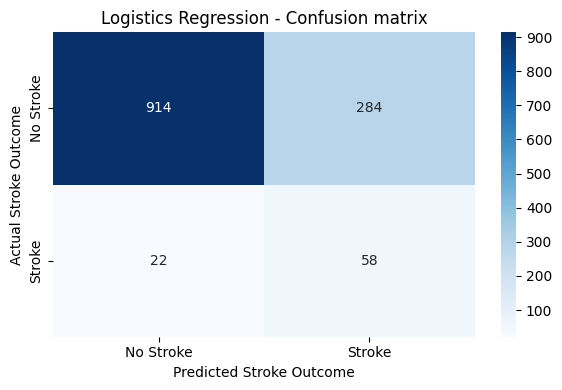

In [25]:
# Best performing model
lr_pipe = pipelines['Logistics Regression']


confusion = confusion_matrix(y_test, lr_pipe.predict(X_test))

labels = ['No Stroke', 'Stroke']

# Visualize the confusion matrix
plt.figure(figsize = (6,4))
sns.heatmap(
    data = confusion,
    annot = True,
    fmt = '.0f',
    cmap = 'Blues',
    xticklabels = labels,
    yticklabels = labels
    
)
plt.xlabel('Predicted Stroke Outcome', fontsize = 10)
plt.ylabel('Actual Stroke Outcome', fontsize = 10)
plt.title('Logistics Regression - Confusion matrix')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning of Logistics Regression

In [26]:
# Define the parameter grid

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator = lr_pipe,
    param_grid = param_grid,
    scoring = 'f1',
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=liblinear; total time=   0.2s
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=liblinear; total time=   0.2s
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=liblinear; total time=   0.2s
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=liblinear; total time=   0.2s
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=saga; total time=   0.2s
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=saga; total time=   0.2s
[CV] END model__C=0.01, model__class_weight=None, model__penalty=l1, model__solver=saga; total time=   0.2s
[CV] END model__C=0.01, model__class_weight=None,


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('knn_imputer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bmi',
                                                                          'age',
                                                                          'avg_glucose_level']),
                                                                        ('encoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'Residence_type',
                                                                          'smoking_status',
                                                                          'bmi_missing'])])),
                                       ('smote', SMOTE(random_state=2025)),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='f1', verbose=2)

In [27]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'saga'}
0.22422296844993123


In [28]:
# Best model from grid search
tuned_lr = grid_search.best_estimator_

tuned_pred = tuned_lr.predict(X_test)

# Metrics
print("\nTuned Logistic Regression Performance on Test Set")
print(f"Accuracy:  {accuracy_score(y_test, tuned_pred):.3f}")
print(f"Precision: {precision_score(y_test, tuned_pred):.3f}")
print(f"Recall:    {recall_score(y_test, tuned_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, tuned_pred):.3f}")


Tuned Logistic Regression Performance on Test Set
Accuracy:  0.760
Precision: 0.169
Recall:    0.725
F1 Score:  0.274


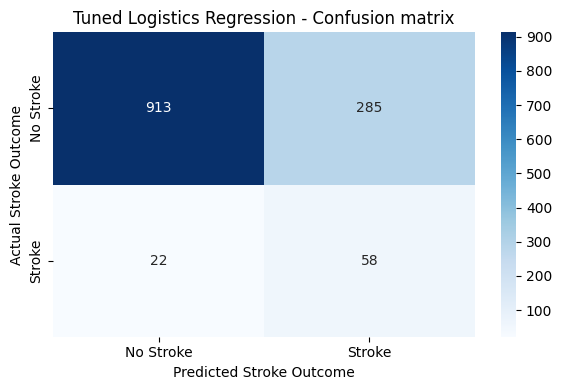

In [29]:
confusion = confusion_matrix(y_test, tuned_pred)

labels = ['No Stroke', 'Stroke']

# Visualize the confusion matrix
plt.figure(figsize = (6,4))
sns.heatmap(
    data = confusion,
    annot = True,
    fmt = '.0f',
    cmap = 'Blues',
    xticklabels = labels,
    yticklabels = labels
    
)
plt.xlabel('Predicted Stroke Outcome', fontsize = 10)
plt.ylabel('Actual Stroke Outcome', fontsize = 10)
plt.title('Tuned Logistics Regression - Confusion matrix')
plt.tight_layout()
plt.show()

## Which is the Best Model?

| Metric            | Untuned Logistic Regression |          Tuned Logistic Regression          | Observation                 |
| :---------------- | :-------------------------: | :-----------------------------------------: | :-------------------------- |
| **Accuracy**      |            0.761            |                    0.760                    | Nearly identical            |
| **Precision**     |            0.182            |                    0.169                    | Slight drop after tuning    |
| **Recall**        |            0.682            |                    0.725                    | Improved detection rate     |
| **F1 Score**      |          **0.281**          |                  **0.274**                  | Slightly lower after tuning |



**Conclusion:**
The untuned model performs slightly better on F1 score.

In [30]:
best_model = lr_pipe.named_steps['model']
preprocessor = lr_pipe.named_steps['preprocessor']

# Can the F1 score be improved with threshold tuning?

In [31]:
y_proba = lr_pipe.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    print(f'Threshold = {t:.2f} | F1 = {f1:.3f} | Precision = {prec:.3f} | Recall = {rec:.3f}')

Threshold = 0.10 | F1 = 0.177 | Precision = 0.097 | Recall = 0.975
Threshold = 0.15 | F1 = 0.195 | Precision = 0.108 | Recall = 0.963
Threshold = 0.20 | F1 = 0.203 | Precision = 0.114 | Recall = 0.925
Threshold = 0.25 | F1 = 0.220 | Precision = 0.125 | Recall = 0.912
Threshold = 0.30 | F1 = 0.232 | Precision = 0.133 | Recall = 0.887
Threshold = 0.35 | F1 = 0.241 | Precision = 0.141 | Recall = 0.838
Threshold = 0.40 | F1 = 0.244 | Precision = 0.145 | Recall = 0.775
Threshold = 0.45 | F1 = 0.258 | Precision = 0.156 | Recall = 0.738
Threshold = 0.50 | F1 = 0.275 | Precision = 0.170 | Recall = 0.725
Threshold = 0.55 | F1 = 0.289 | Precision = 0.182 | Recall = 0.700
Threshold = 0.60 | F1 = 0.310 | Precision = 0.201 | Recall = 0.675
Threshold = 0.65 | F1 = 0.322 | Precision = 0.216 | Recall = 0.625
Threshold = 0.70 | F1 = 0.338 | Precision = 0.233 | Recall = 0.613
Threshold = 0.75 | F1 = 0.357 | Precision = 0.262 | Recall = 0.562
Threshold = 0.80 | F1 = 0.341 | Precision = 0.275 | Recall = 0

**At t = 0.75**

* F1 = 0.357 (maximum F1) — best balance between precision and recall

* Recall = 0.56 — identifies 56% of stroke patients

* Precision = 0.26 — of those flagged, 26% truly have a stroke

* Interpretation: Balanced option that reduces false alarms while still catching a majority of true cases.

**At t = 0.30**

F1 = 0.232

* Recall = 0.88 — identifies 88% of stroke patients

* Precision = 0.13 — of those flagged, 13% truly have a stroke

* Interpretation: Screening-focused option that catches many more true positives at the cost of many more false positives.


Since the aim of this model is to identify, as many as possible, stroke patients, t = 0.30.

In [32]:
t = 0.30

final_pred = (y_proba >= t).astype(int)

accuracy = accuracy_score(y_test, final_pred)
precision = precision_score(y_test, final_pred)
recall = recall_score(y_test, final_pred)
f1 = f1_score(y_test, final_pred)

print(f"Threshold = {t}")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

Threshold = 0.3
Accuracy:  0.632
Precision: 0.133
Recall:    0.887
F1 Score:  0.232


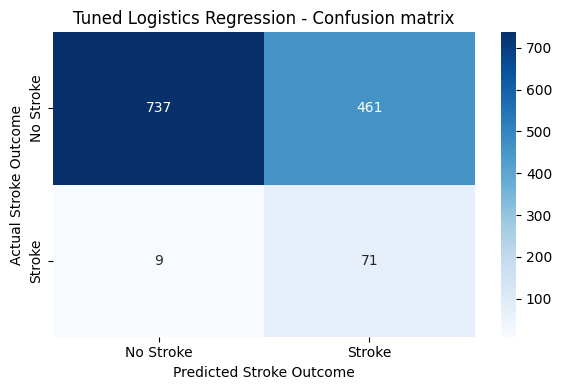

In [33]:
# Confusion matrix at t = 30

confusion = confusion_matrix(y_test, final_pred)

labels = ['No Stroke', 'Stroke']

# Visualize the confusion matrix
plt.figure(figsize = (6,4))
sns.heatmap(
    data = confusion,
    annot = True,
    fmt = '.0f',
    cmap = 'Blues',
    xticklabels = labels,
    yticklabels = labels
    
)
plt.xlabel('Predicted Stroke Outcome', fontsize = 10)
plt.ylabel('Actual Stroke Outcome', fontsize = 10)
plt.title('Tuned Logistics Regression - Confusion matrix')
plt.tight_layout()
plt.show()

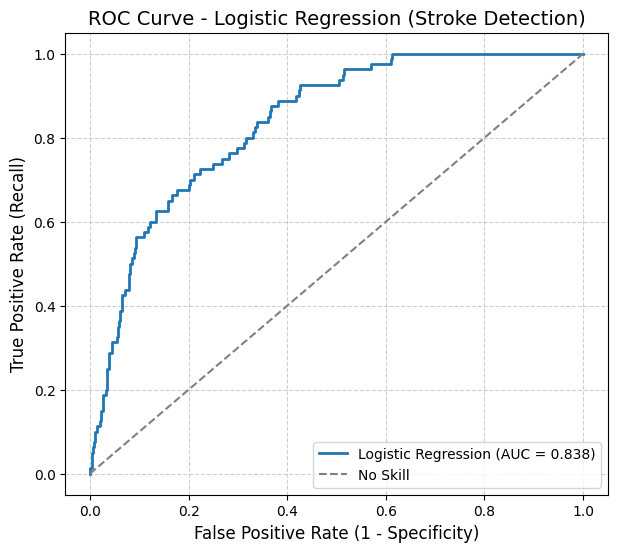

ROC-AUC Score: 0.838


In [34]:
# ROC-AUC Score

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.figure(figsize = (7, 6))
plt.plot(fpr, tpr, label = f'Logistic Regression (AUC = {roc_auc:.3f})', linewidth = 2)
plt.plot([0, 1], [0, 1], linestyle ='--', color = 'gray', label = 'No Skill')

plt.title('ROC Curve - Logistic Regression (Stroke Detection)', fontsize = 14)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 12)
plt.ylabel('True Positive Rate (Recall)', fontsize = 12)
plt.legend(loc = 'lower right')
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.3f}")

# Model Interpretation

For a Logistic Regression model, feature importance is determined through the magnitude andd direction of the model coefficients.

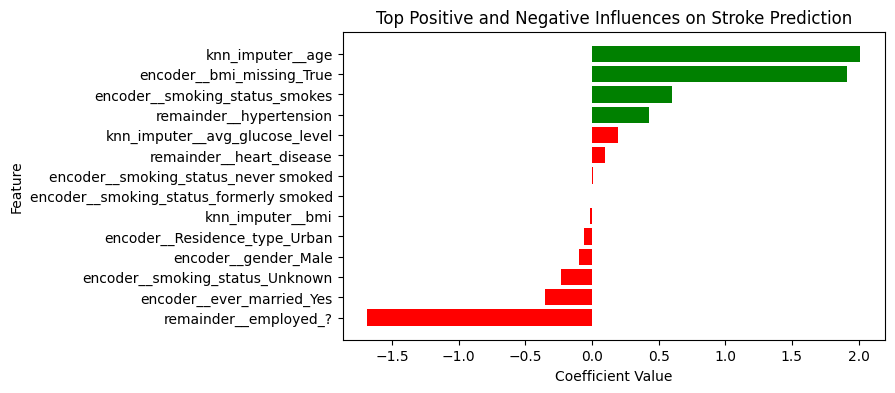

In [35]:
feature_names = preprocessor.get_feature_names_out()
coefficients = best_model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot
top_features = coef_df.head(10)
bottom_features = coef_df.tail(10)

plt.figure(figsize = (7,4))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='green')
plt.barh(bottom_features['Feature'], bottom_features['Coefficient'], color='red')
plt.title('Top Positive and Negative Influences on Stroke Prediction')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

**Top +ve Influence on Stroke Risk**
* Age: strongest predictor
* Missing BMI
* Smoking Status (smokes) - active smokers are likely to have a stroke
* Hypertension
* Elevated glucose level

**Top -ve Influences**
* Employe_? = Yes: employed patients have lower risk
* Ever_married = Yes: at lower risk
* Unknown and Never Smoked patients
* Gender = Male

The findings after modelling is consistent with EDA - Age, Hypertension and Glucose level are strong predictors.